In [35]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
import time

from stance_leg_controller import ForceStanceLegController

from quadruped_jax import QuadrupedQPProjector

import matplotlib.pyplot as plt

#jax.config.update("jax_enable_x64", True)

In [36]:
num_batch=1  # Increased batch size to demonstrate batching
maxiter=500
rho=1
desired_speed=(-0.1, 0.1)
desired_twisting_speed=0.0
desired_body_height=0.5
body_mass=30.0
body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
num_legs=4
friction_coeff=0.1
timestep=0.05
horizon=10
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

In [37]:
# Initialize the projector with organized parameters
projector = QuadrupedQPProjector(
    num_batch=num_batch,
    maxiter=maxiter,
    rho=rho,
    desired_speed=desired_speed,
    desired_twisting_speed=desired_twisting_speed,
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    foot_x=foot_x,
    foot_y=foot_y,
    foot_z=foot_z
)


    

ComVelocityBodyFrame (0.0, 0.0, 0.0)
self.num_total_constraints 240


In [38]:
# Print problem information
projector.print_problem_info()

# Sample batched initial guess
key = jax.random.PRNGKey(42)


lamda_init = jnp.zeros((projector.num_batch, projector.nvar))
s_init =jnp.zeros((projector.num_batch, projector.num_total_constraints))   

#print(f"Initial xi batch shape: {xi_init.shape}")
print(f"Initial lambda batch shape: {lamda_init.shape}")

xi_init = jnp.zeros((projector.num_batch, projector.nvar))
for i in range(projector.num_legs*projector.horizon):
        xi_init = xi_init.at[:, 3*i+2].set(body_mass * 9.81 / 4.0)

=== Quadruped QP Problem Information ===
H matrix shape: (120, 120)
g vector shape: (120,)
C matrix shape: (240, 120)
constraint limit vector shape: (240,)
Number of variables: 120
Number of constraints: 240
Batch size: 1
Max iterations: 500
ADMM penalty (rho): 1
Initial lambda batch shape: (1, 120)


In [39]:
force_input = -xi_init[:, :12]
print(f"Initial Force Input shape: {force_input.shape}")
print(f"Initial Force Input: {force_input[0]}")

Initial Force Input shape: (1, 12)
Initial Force Input: [ -0.     -0.    -73.575  -0.     -0.    -73.575  -0.     -0.    -73.575
  -0.     -0.    -73.575]


In [40]:
# Solve batched QP projection
start_time = time.time()
xi_proj, primal_residual, fixed_point_residual = projector.compute_qp_projection(xi_init, lamda_init, s_init, use_zero_s_init=False)
solve_time = time.time() - start_time

cost.shape (120, 120)
cost.shape (120, 120)


In [41]:
print(f"\n=== Solution Results ===")
print(f"Projection time: {solve_time:.6f} seconds")
print(f"Projected xi batch shape: {xi_proj.shape}")
print(f"Final primal residual shape: {primal_residual[-1].shape}")
print(f"Final dual residual shape: {fixed_point_residual[-1].shape}")

# Display convergence statistics
primal_residual_np = np.array(primal_residual)
fixed_point_residual_np = np.array(fixed_point_residual)

print(f"\n=== Convergence Statistics ===")
print(f"Primal residual - Initial (mean): {np.mean(primal_residual_np[0]):.6f}, Final (mean): {np.mean(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Initial (mean): {np.mean(fixed_point_residual_np[0]):.6f}, Final (mean): {np.mean(fixed_point_residual_np[-1]):.6f}")
print(f"Primal residual - Final (max): {np.max(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Final (max): {np.max(fixed_point_residual_np[-1]):.6f}")

# Extract force outputs (first 12 elements as in original code) for all batches
force_output = -xi_proj[:, :12]
print(f"\n=== Force Output ===")
print(f"Projected forces batch shape: {force_output.shape}")
print(f"First batch projected forces: {force_output[0]}")

print("\nBatched Quadruped QP projection complete!")


=== Solution Results ===
Projection time: 0.225014 seconds
Projected xi batch shape: (1, 120)
Final primal residual shape: (1,)
Final dual residual shape: (1,)

=== Convergence Statistics ===
Primal residual - Initial (mean): 0.000000, Final (mean): 0.000000
Dual residual - Initial (mean): 0.010051, Final (mean): 0.005511
Primal residual - Final (max): 0.000000
Dual residual - Final (max): 0.005511

=== Force Output ===
Projected forces batch shape: (1, 12)
First batch projected forces: [  4.314358   -4.31363   -73.36617     4.3149176  -4.314249  -52.141987
   4.3138084  -4.3139687 -94.58819     4.3141074  -4.3145285 -73.36475  ]

Batched Quadruped QP projection complete!


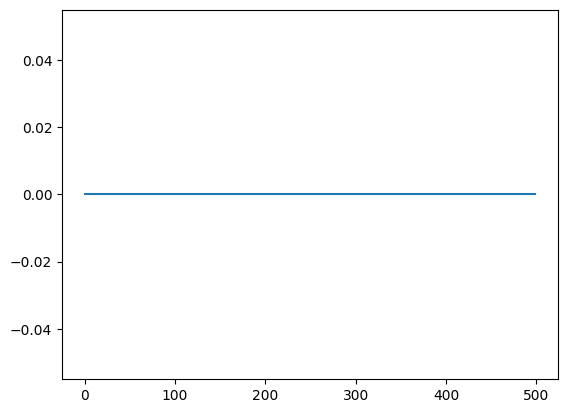

In [42]:
%matplotlib inline
plt.figure()
plt.plot(primal_residual)
plt.show()

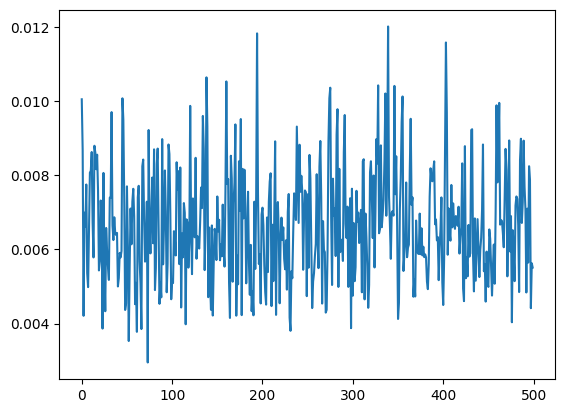

In [43]:
%matplotlib inline
plt.figure()
plt.plot(fixed_point_residual)
plt.show()

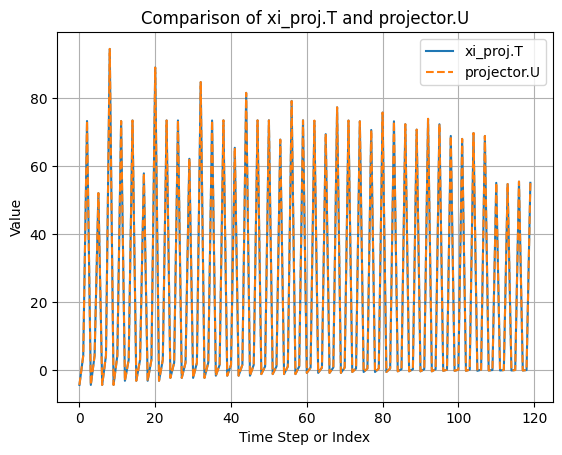

In [44]:
%matplotlib inline
plt.figure()
plt.plot(xi_proj.T, label="xi_proj.T", linestyle="-")  
plt.plot(projector.U, label="projector.U", linestyle="--")
plt.legend()
plt.title("Comparison of xi_proj.T and projector.U")
plt.xlabel("Time Step or Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [45]:
print("\nBatched Quadruped QP projection complete!")

print("Check default Qp solvers")
print("U", projector.U.shape)
print("U", -projector.U[:12])



Batched Quadruped QP projection complete!
Check default Qp solvers
U (120,)
U [  4.3150468   -4.31504376 -73.3666263    4.3104052   -4.3104116
 -52.14134895   4.3151262   -4.31512706 -94.5928153    4.31504415
  -4.3150411  -73.36662768]


In [46]:
print("xi_proj", xi_proj.shape)
xi_proj_mean = np.mean(xi_proj, axis=0)
print("xi_proj_mean", xi_proj_mean.shape)

# xi_proj and projector.U are both 1D vectors with repeating x, y, z pattern
xi_x = xi_proj_mean[0::3]
xi_y = xi_proj_mean[1::3]
xi_z = xi_proj_mean[2::3]

print(xi_x.shape)

U_x = projector.U[0::3]
U_y = projector.U[1::3]
U_z = projector.U[2::3]

print(U_x.shape)


xi_proj (1, 120)
xi_proj_mean (120,)
(40,)
(40,)


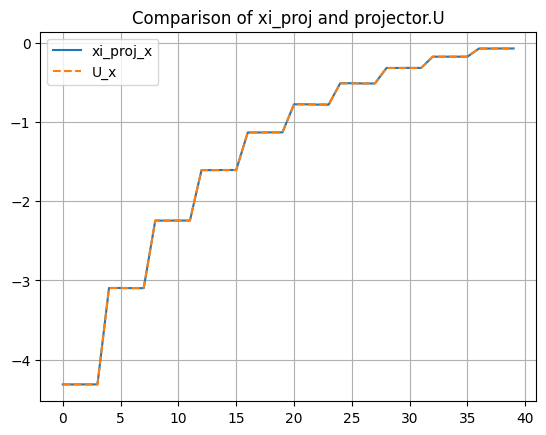

In [47]:
%matplotlib inline
plt.figure()
plt.title("Comparison of xi_proj and projector.U")
plt.plot(xi_x, label="xi_proj_x", linestyle="-")
plt.plot(U_x, label="U_x", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()

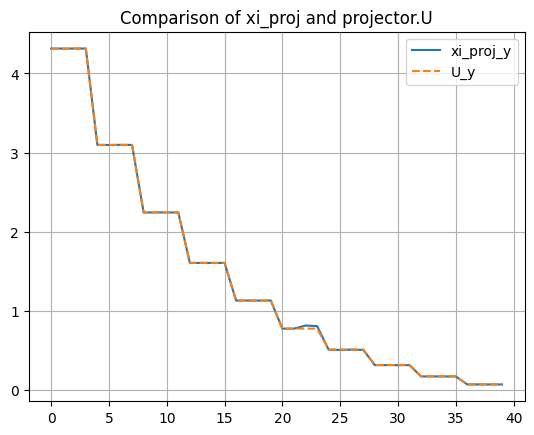

In [48]:
%matplotlib inline
plt.figure()
plt.title("Comparison of xi_proj and projector.U")
plt.plot(xi_y, label="xi_proj_y", linestyle="-")
plt.plot(U_y, label="U_y", linestyle="--")
plt.legend()
plt.grid(True)
plt.show()


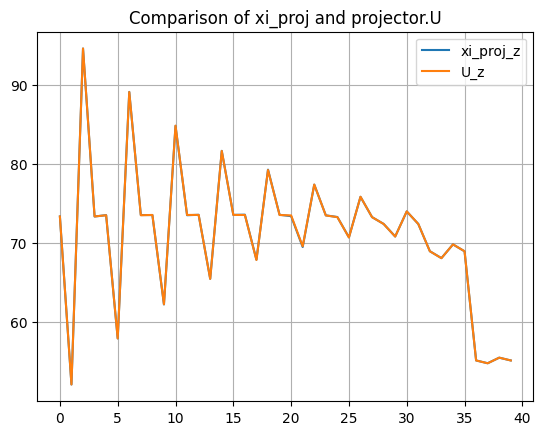

In [49]:
%matplotlib inline
plt.figure()

plt.title("Comparison of xi_proj and projector.U")
plt.plot(xi_z,label="xi_proj_z", linestyle="-")
plt.plot(U_z,label="U_z", linestyle="-")
plt.legend()
plt.grid(True)
plt.show()

In [50]:

#Difference between Clarable and Our Own Augmented Lagrangian solver
print("Difference between Clarable and Our Own Augmented Lagrangian solver")
diff = projector.U-xi_proj_mean
print("xi_proj", xi_proj_mean.shape)
print("Differnce", diff.shape)
print("Max difference", diff.max())    
print("Min difference", diff.min()) 

# Find the index of the max and min elements
max_idx = np.unravel_index(np.argmax(diff), diff.shape)
min_idx = np.unravel_index(np.argmin(diff), diff.shape)

# Print values and their locations
print("Max difference:", diff[max_idx], "at index", max_idx)
print("Min difference:", diff[min_idx], "at index", min_idx)   

Difference between Clarable and Our Own Augmented Lagrangian solver
xi_proj (120,)
Differnce (120,)
Max difference 0.094703674
Min difference -0.046066284
Max difference: 0.094703674 at index (np.int64(62),)
Min difference: -0.046066284 at index (np.int64(56),)


In [51]:
print("Difference between Clarable and Our Own Augmented Lagrangian solver")
diff_x = U_x-xi_x
diff_y = U_y-xi_y
diff_z = U_z-xi_z
# Find the index of the max and min elements 
max_idx_x = np.unravel_index(np.argmax(diff_x), diff_x.shape)
min_idx_x = np.unravel_index(np.argmin(diff_x), diff_x.shape)

max_idx_y = np.unravel_index(np.argmax(diff_y), diff_y.shape)
min_idx_y = np.unravel_index(np.argmin(diff_y), diff_y.shape)

max_idx_z = np.unravel_index(np.argmax(diff_z), diff_z.shape)
min_idx_z = np.unravel_index(np.argmin(diff_z), diff_z.shape)

# Print values and their locations
print("Max difference x:", diff_x[max_idx_x], "at index", max_idx_x)
print("Min difference x:", diff_x[min_idx_x], "at index", min_idx_x)  

print("Max difference y:", diff_y[max_idx_y], "at index", max_idx_y)   
print("Min difference y:", diff_y[min_idx_y], "at index", min_idx_y)  
 
print("Max difference z:", diff_z[max_idx_z], "at index", max_idx_z)   
print("Min difference z:", diff_z[min_idx_z], "at index", min_idx_z)   

Difference between Clarable and Our Own Augmented Lagrangian solver
Max difference x: 0.00451231 at index (np.int64(1),)
Min difference x: -0.0025260448 at index (np.int64(24),)
Max difference y: 0.005414486 at index (np.int64(27),)
Min difference y: -0.038964033 at index (np.int64(22),)
Max difference z: 0.094703674 at index (np.int64(20),)
Min difference z: -0.046066284 at index (np.int64(18),)
